<a href="https://colab.research.google.com/github/boomboom0202/IDID/blob/main/x101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import cv2
import matplotlib.pyplot as plt
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/project/dataset/train_coco_labels.json", "/content/drive/MyDrive/project/dataset/images/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/project/dataset/val_coco_labels.json", "/content/drive/MyDrive/project/dataset/images/val")


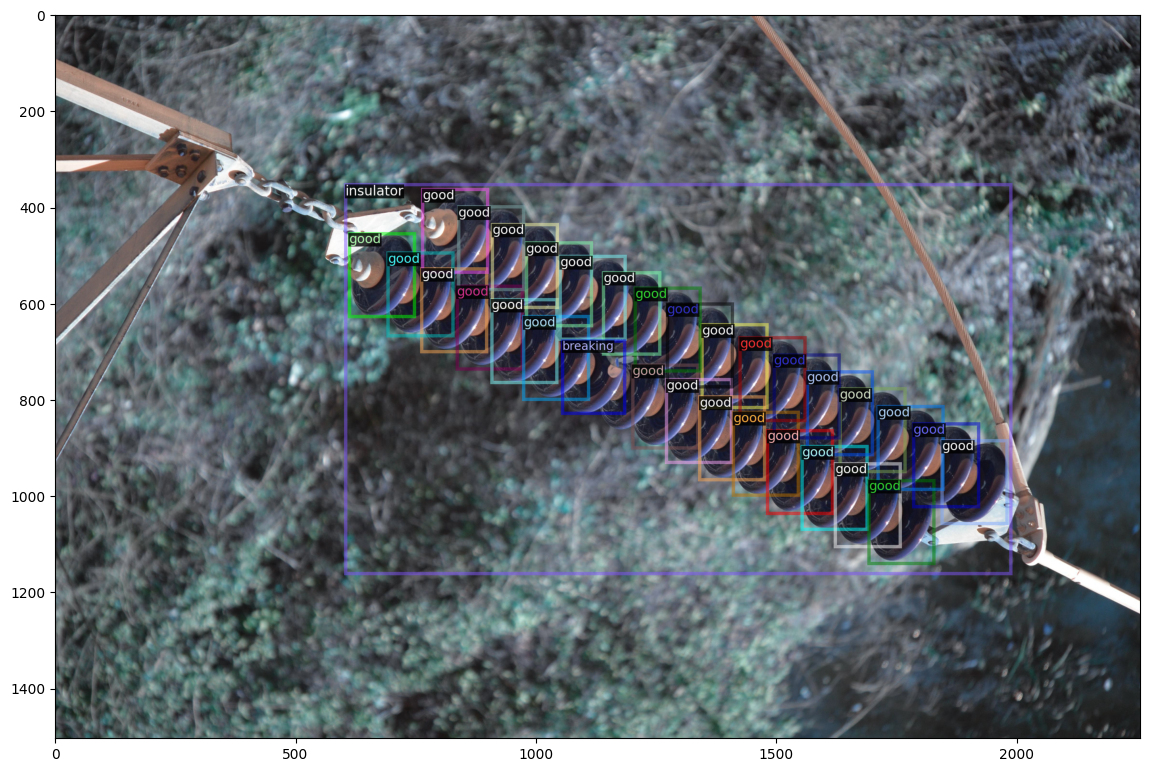

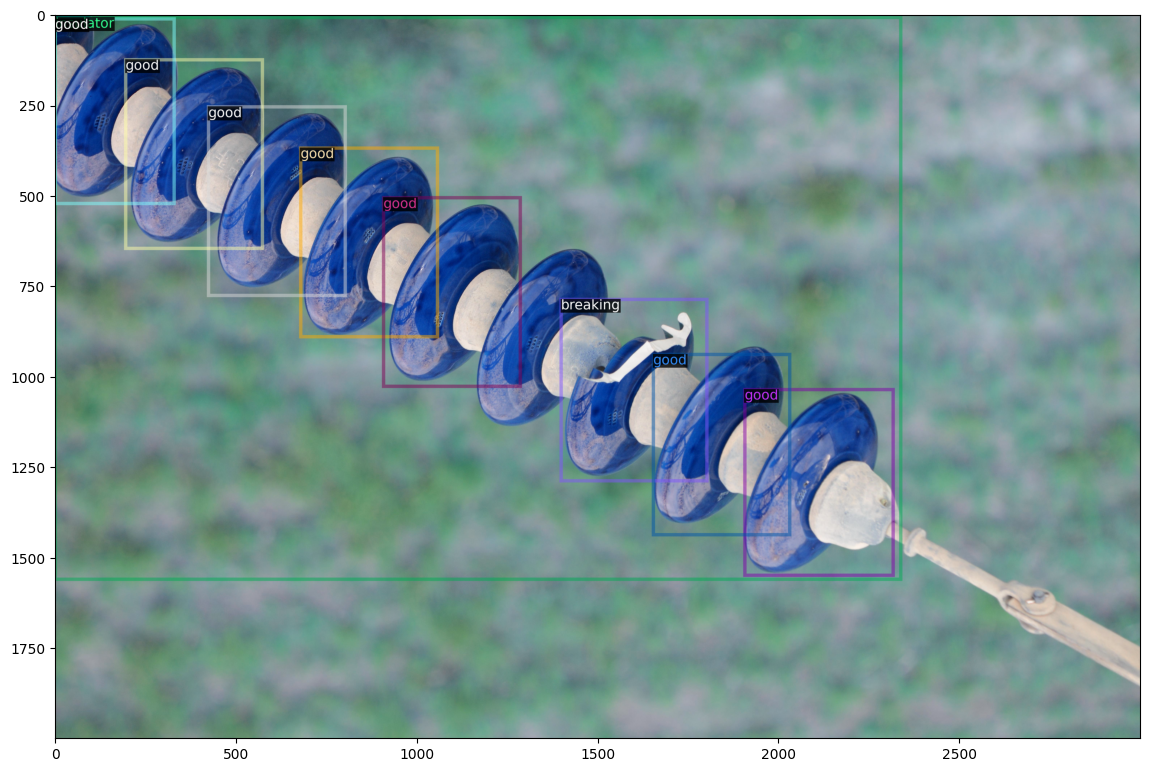

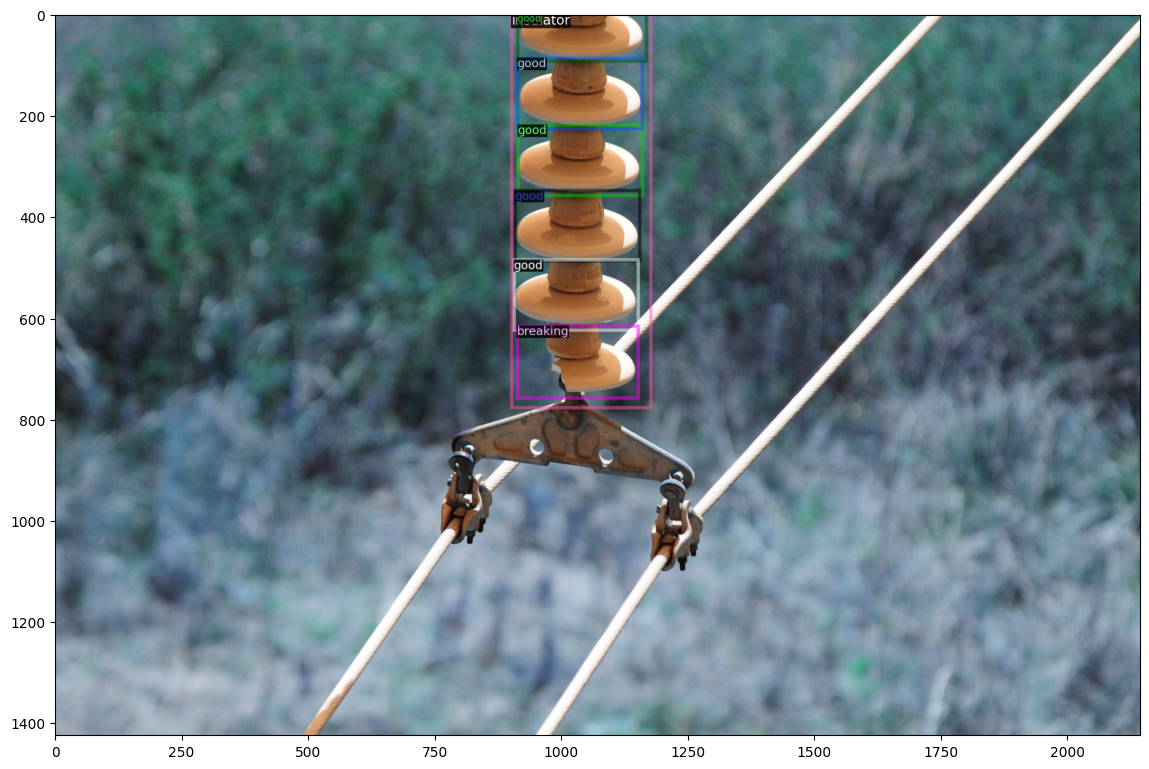

In [6]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [7]:
from detectron2.data import DatasetMapper
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.build import build_detection_test_loader
from detectron2.config import get_cfg
def get_detection_augmentation():
    return [
        T.Resize((640, 640)),  # Изменение размера изображений
        T.RandomFlip(horizontal=True, vertical=False),  # Случайное отражение
        T.RandomBrightness(0.8, 1.2),  # Изменение яркости
        T.RandomContrast(0.8, 1.2),  # Изменение контрастности
        T.RandomRotation(angle=[-10, 10]),  # Случайный поворот
        T.RandomCrop("relative_range", (0.8, 0.8)),  # Случайная обрезка
        T.ToTensor(),  # Преобразование в тензор
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Нормализация
    ]
# Определите веса классов
class_weights = [1.0, 2.0, 3.0, 4.0, 10.0]  # Увеличьте вес для классов с меньшим количеством меток

# Используйте DatasetMapper для учета весов классов
class CustomDatasetMapper(DatasetMapper):
    def __init__(self, cfg, is_train=True):
        super().__init__(cfg, is_train=is_train)
        self.augments = get_detection_augmentation()  # Используйте ваши аугментации
        self.class_weights = cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS

    def __call__(self, dataset_dict):
        dataset_dict = super().__call__(dataset_dict)  # Примените базовые аугментации
        # Примените ваши кастомные аугментации
        for a in self.augments:
            dataset_dict = a(dataset_dict)

        # Применение весов классов
        if self.is_train:
            for instance in dataset_dict["annotations"]:
                class_id = instance["category_id"]
                instance["weight"] = self.class_weights[class_id]

        return dataset_dict


cfg = get_cfg()
cfg.MODEL.ROI_HEADS.LOSS = "focal"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS = class_weights

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.OUTPUT_DIR = "/content/drive/MyDrive/project/dataset/output_rcnn_101"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Замените стандартный загрузчик данных на кастомный
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/03 23:58:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/03 23:58:05 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/03 23:59:34 d2.utils.events]:  eta: 0:33:56  iter: 19  total_loss: 3.774  loss_cls: 2.089  loss_box_reg: 0.8436  loss_rpn_cls: 0.8246  loss_rpn_loc: 0.07106    time: 4.2959  last_time: 4.0167  data_time: 0.2455  last_data_time: 0.0152   lr: 9.7405e-06  max_mem: 9975M
[10/04 00:01:07 d2.utils.events]:  eta: 0:33:11  iter: 39  total_loss: 3.097  loss_cls: 1.836  loss_box_reg: 0.8941  loss_rpn_cls: 0.2862  loss_rpn_loc: 0.06102    time: 4.3822  last_time: 3.9017  data_time: 0.2660  last_data_time: 0.0113   lr: 1.9731e-05  max_mem: 9975M
[10/04 00:02:37 d2.utils.events]:  eta: 0:32:49  iter: 59  total_loss: 2.553  loss_cls: 1.518  loss_box_reg: 0.9485  loss_rpn_cls: 0.02139  loss_rpn_loc: 0.05222    time: 4.4186  last_time: 4.6550  data_time: 0.0113  last_data_time: 0.0093   lr: 2.972e-05  max_mem: 9975M
[10/04 00:04:08 d2.utils.events]:  eta: 0:31:26  iter: 79  total_loss: 2.2  loss_cls: 1.215  loss_box_reg: 0.9228  loss_rpn_cls: 0.02055  loss_rpn_loc: 0.05209    time: 4.4613  last_ti

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")


[10/04 00:36:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/project/dataset/output_rcnn_101/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

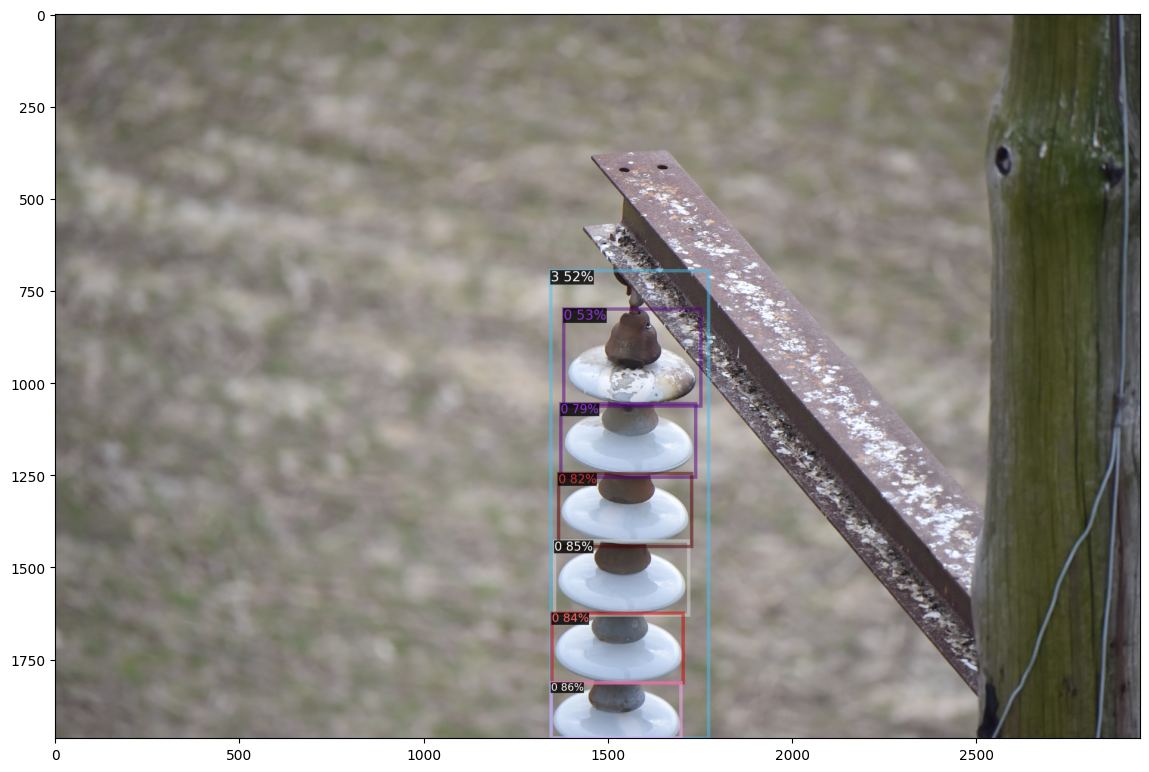

In [9]:
# prompt: Сделай predict на изображение /content/drive/MyDrive/project/dataset/images/test/170635 (2).JPG

import matplotlib.pyplot as plt
im = cv2.imread("/content/drive/MyDrive/project/dataset/images/test/170635 (2).JPG")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8,
                instance_mode=cv2.COLOR_BGR2RGB)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()


In [10]:
import json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Инициализация оценщика
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/content/drive/MyDrive/project/dataset/output_rcnn_101")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Выполнение оценки
results = inference_on_dataset(trainer.model, val_loader, evaluator)

# Печать результатов
print(results)

# Сохранение результатов в JSON файл
output_path = "/content/drive/MyDrive/project/dataset/output_rcnn_101/evaluation_results.json"
with open(output_path, 'w') as f:
    json.dump(results, f)

print(f"Метрики сохранены в {output_path}")

[10/04 00:36:24 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [10/04 00:36:24 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/04 00:36:25 d2.data.datasets.coco]: Loaded 212 images in COCO format from /content/drive/MyDrive/project/dataset/val_coco_labels.json
[10/04 00:36:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/04 00:36:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/04 00:36:25 d2.data.common]: Serializing 212 elements to byte tensors and concatenating them all ...
[10/04 00:36:25 d2.data.common]: Serialized dataset takes 0.18 MiB
[10/04 00:36:25 d2.evaluation.evaluator]: Start inference on 212 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[10/04 00:36:35 d2.evaluation.evaluator]: Inference done 11/212. Dataloading: 0.2815 s/iter. Inference: 0.2681 s/iter. Eval: 0.0003 s/iter. Total: 0.5499 s/iter. ETA=0:01:50
[10/04 00:36:40 d2.evaluation.evaluator]: Inference done 19/212. Dataloading: 0.3581 s/iter. Inference: 0.2683 s/iter. Eval: 0.0003 s/iter. Total: 0.6269 s/iter. ETA=0:02:00
[10/04 00:36:47 d2.evaluation.evaluator]: Inference done 29/212. Dataloading: 0.3548 s/iter. Inference: 0.2681 s/iter. Eval: 0.0003 s/iter. Total: 0.6235 s/iter. ETA=0:01:54
[10/04 00:36:52 d2.evaluation.evaluator]: Inference done 37/212. Dataloading: 0.3674 s/iter. Inference: 0.2681 s/iter. Eval: 0.0003 s/iter. Total: 0.6360 s/iter. ETA=0:01:51
[10/04 00:36:58 d2.evaluation.evaluator]: Inference done 47/212. Dataloading: 0.3499 s/iter. Inference: 0.2678 s/iter. Eval: 0.0003 s/iter. Total: 0.6182 s/iter. ETA=0:01:42
[10/04 00:37:16 d2.evaluation.evaluator]: Inference done 51/212. Dataloading: 0.6884 s/iter. Inference: 0.2687 s/iter. Eval: 0.000

In [11]:
%load_ext tensorboard
%tensorboard --logdir

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-10-04 00:39:00.701560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 00:39:00.721309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 00:39:00.727263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 00:39:01.827480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f